In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
uncleaned_data = "Uncleaned_Audio_Books.csv"

# reading a csv file using pandas library
df = pd.read_csv(uncleaned_data)

#showing the first 5 rows
df.head(5)

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820


The "stars" column contains text like "5 out of 5 stars34 ratings" - needs extraction of just the rating

The "price" column has some values with commas (like "1,256.00") that need to be converted to numeric

The "time" column needs conversion from "X hrs and Y mins" to total minutes

The "releasedate" is in DD-MM-YY format and needs standardization


***KEY QUESTIONS***     
1- which book has the highest rating while the price is between 1000 and 2000 published after 2015  
2- what is the average price of spanish books published after 2018  
3- what's the average time of books written by RickRiodan      

In [3]:
df.info()
df.shape    # prints out the shape in this case its (87489, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         87489 non-null  object
 1   author       87489 non-null  object
 2   narrator     87489 non-null  object
 3   time         87489 non-null  object
 4   releasedate  87489 non-null  object
 5   language     87489 non-null  object
 6   stars        87489 non-null  object
 7   price        87489 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


(87489, 8)

In [4]:
# prints out sum of null values in each column in this case its 0 :D
df.isnull().sum()

name           0
author         0
narrator       0
time           0
releasedate    0
language       0
stars          0
price          0
dtype: int64

In [5]:
# prints out column names 
# the reason behind this is to check if there's any unwanted characters or nota
df.columns.tolist()

['name',
 'author',
 'narrator',
 'time',
 'releasedate',
 'language',
 'stars',
 'price']

In [6]:
df.describe()

,name,author,narrator,time,releasedate,language,stars,price
count,87489,87489,87489,87489,87489,87489,87489,87489
unique,82767,48374,29717,2284,5058,36,665,1011
top,The Art of War,"Writtenby:矢島雅弘,石橋遊",Narratedby:anonymous,2 mins,16-05-18,English,Not rated yet,586
freq,20,874,1034,372,773,61884,72417,5533


In [7]:
# prints out sum of duplicared rows which in this case its 0 :D
print("\nDuplicate rows:")
df.duplicated().sum()


Duplicate rows:


0

In [8]:
# extracting numeric ratings from stars and storing them in a new column

# this part uses regex to extract the numeric part before "ratings"
# (\d+) captures one or more digits
# \s* allows for optional whitespace
# ratings$ matches "ratings" at the end of the string
# creates a new column 'rating' with these extracetd values
df['ratings'] = df['stars'].str.extract(r'(\d+)\s*rating[s]?$')[0].fillna('0').astype(int)


# same thing but instead of extracting it, it replaces the rating part with an empty string
df['stars'] = df['stars'].str.replace(r'\s*\d+\s*rating[s]?$', '', regex=True)


# removes any leading or trailing whitespaces to ensure clean formatting
df['stars'] = df['stars'].str.strip()


df.head()

,name,author,narrator,time,releasedate,language,stars,price,ratings
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars,468,34
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars,820,41
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars,410,38
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars,615,12
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars,820,181


In [9]:
# some price entries are 'Free' so we have to handle these non-numeric values
# stores the cleaned values back in the original 'price' column

df['price'] = (
    df['price']
    .astype(str)            # converts all values to string for consistent handling
    .str.strip('"\'').replace('Free', '0').str.replace(',', '')   
                                # removes any single or double quotes surrounding the prices
                                # replaces the string "Free" with 0
                                # removes commas from numbers
    .replace('', np.nan)    # converts empty string to NaN (if any)
    .astype(float)          # converts all values to float (necessary for mathematical operations)
    .fillna(0)              # replaces NaN values with 0
)

df.head()

,name,author,narrator,time,releasedate,language,stars,price,ratings
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars,468.0,34
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars,820.0,41
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars,410.0,38
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars,615.0,12
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars,820.0,181


In [10]:
# this function converts time to minutes
 
def calculate_time(time_str):
    hrs = re.findall(r'(\d+)\s*hrs?', time_str)     # using '?' makes the 's' optional
    mins = re.findall(r'(\d+)\s*mins?', time_str)   # ex: "2hrs" or "2hr" both returns "2"
    total = 0

    if hrs:
        total += int(hrs[0]) * 60
    if mins:
        total += int(mins[0])
    return total

df['time'] =df['time'].apply(calculate_time)

df.head()

,name,author,narrator,time,releasedate,language,stars,price,ratings
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,140,04-08-08,English,5 out of 5 stars,468.0,34
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,788,01-05-18,English,4.5 out of 5 stars,820.0,41
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,123,06-11-20,English,4.5 out of 5 stars,410.0,38
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,676,05-10-21,English,4.5 out of 5 stars,615.0,12
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,600,13-01-10,English,4.5 out of 5 stars,820.0,181


In [11]:
# fixing the dates
# the dates are in DD-MM-YY format but some may be in MM-DD-YY


# parse dates in day-month-year format and converts unparseable dates to NaT (Not a Time)
df['releasedate'] = pd.to_datetime(df['releasedate'], format='%d-%m-%y', errors='coerce')


# creates a mask where NaT vales are True and parsed dates are False
# second attempt on NaT values in month-day-year format
mask = df['releasedate'].isna()
df.loc[mask, 'releasedate'] = pd.to_datetime(df.loc[mask, 'releasedate'], format='%m-%d-%y', errors='coerce')


df.head()

,name,author,narrator,time,releasedate,language,stars,price,ratings
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,140,2008-08-04,English,5 out of 5 stars,468.0,34
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,788,2018-05-01,English,4.5 out of 5 stars,820.0,41
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,123,2020-11-06,English,4.5 out of 5 stars,410.0,38
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,676,2021-10-05,English,4.5 out of 5 stars,615.0,12
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,600,2010-01-13,English,4.5 out of 5 stars,820.0,181


In [12]:
# replaces 'Writtenby:' and 'Narratedby:' with an empty string
df['author'] = df['author'].str.replace('Writtenby:', '')
df['narrator'] = df['narrator'].str.replace('Narratedby:', '')

df.head()

,name,author,narrator,time,releasedate,language,stars,price,ratings
0,Geronimo Stilton #11 & #12,GeronimoStilton,BillLobely,140,2008-08-04,English,5 out of 5 stars,468.0,34
1,The Burning Maze,RickRiordan,RobbieDaymond,788,2018-05-01,English,4.5 out of 5 stars,820.0,41
2,The Deep End,JeffKinney,DanRussell,123,2020-11-06,English,4.5 out of 5 stars,410.0,38
3,Daughter of the Deep,RickRiordan,SoneelaNankani,676,2021-10-05,English,4.5 out of 5 stars,615.0,12
4,"The Lightning Thief: Percy Jackson, Book 1",RickRiordan,JesseBernstein,600,2010-01-13,English,4.5 out of 5 stars,820.0,181


<Figure size 1000x600 with 0 Axes>

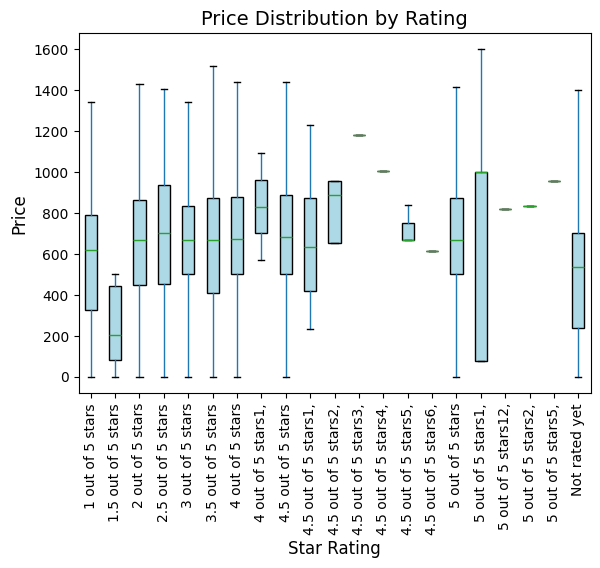

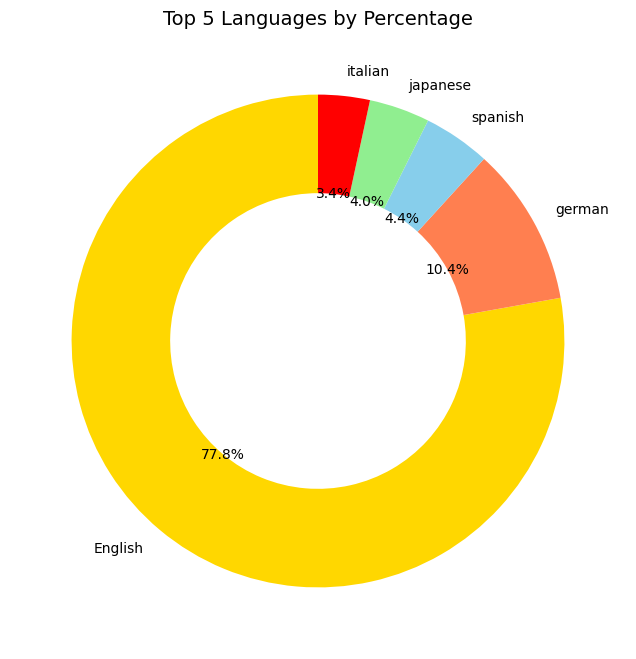

In [13]:
plt.figure(figsize=(10, 6))
df.boxplot(column='price', by='stars', grid=False, 
           showfliers=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue'))
plt.title('Price Distribution by Rating', fontsize=14)
plt.suptitle('')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(8, 8))
df['language'].value_counts().head(5).plot(
    kind='pie', autopct='%1.1f%%', 
    colors=['gold', 'coral', 'skyblue', 'lightgreen', 'red'],
    startangle=90, wedgeprops=dict(width=0.4))
plt.title('Top 5 Languages by Percentage', fontsize=14)
plt.ylabel('')
plt.show()

In [14]:
# top 5 highest rated books
top_rated = df.sort_values('stars', ascending=False).head(5)
print(top_rated[['name', 'author', 'stars']])

print("----------------------------------------------------------------------")

# shortest and longest books
shortest = df.sort_values('time').head(3)
longest = df.sort_values('time', ascending=False).head(3)

print("\nShortest Books:")
print(shortest[['name', 'time']])
print("\nLongest Books:")
print(longest[['name', 'time']])

print("----------------------------------------------------------------------")

# most expensive books
expensive = df.sort_values('price', ascending=False).head(3)
print("\nMost Expensive Books:")
print(expensive[['name', 'price']])

                                           name        author          stars
43744                      Conspiracy of Ravens     LilaBowen  Not rated yet
55977                            Biker Beauties  AudreyCarlan  Not rated yet
55985                 Monster Girl in My Closet    JamieHawke  Not rated yet
55984                    Chaos at Prescott High   C.M.Stunich  Not rated yet
55983  Depois da despedida [After the Farewell]     SaraEster  Not rated yet
----------------------------------------------------------------------

Shortest Books:
                                name  time
87099  第五話アテナイの幻想:ぼくの旅の手帖〜または珈琲のある風景     1
9437             Let's Explore Gases     1
9431         Sensing Light and Sound     1

Longest Books:
                                           name  time
51330                                  All DEAD  8595
38010  The Decline and Fall of the Roman Empire  7591
5473                         鈴木三重吉童話全集（全270話収録）  7363
----------------------------------------------

In [15]:
# asnwering key questions
#Q1
# filter for books in the given price range and release date
filtered = df[
    (df['price'].between(1000, 2000)) &
    (df['releasedate'] > '2015-12-31')
]
highest_rated = filtered.sort_values('stars', ascending=False).head(1)  # sort in decending order
print(highest_rated[['name', 'author', 'stars', 'price', 'releasedate']])


print("----------------------------------------------------------------------")


#Q2
# case=False ===> case-insensitive search
spanish_books = df[
    (df['language'].str.contains('Spanish', case=False)) & 
    (df['releasedate'] > '2018-12-31')
]
avg_price = spanish_books['price'].mean()
print(f"\nAverage price of Spanish books published after 2018: {avg_price:.2f}")


print("----------------------------------------------------------------------")


rick_books = df[df['author'].str.contains('RickRiordan', case=False)]
avg_time = rick_books['time'].mean()
print(f"\nAverage time of Rick Riordan books: {avg_time}")

                                name                                  author  \
50458  Die Wächterinnen von New York  N.K.Jemisin,BenjaminMildner-Übersetzer   

               stars   price releasedate  
50458  Not rated yet  1005.0  2022-03-19  
----------------------------------------------------------------------

Average price of Spanish books published after 2018: 439.33
----------------------------------------------------------------------

Average time of Rick Riordan books: 566.3617021276596


In [16]:
# saving cleaned data
df.to_csv('Cleaned_Audio_Books.csv', index=False)